# Homework 4

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df1 = pd.read_csv('homework_4.1.csv', index_col=0)
df2a = pd.read_csv('homework_4.2.a.csv', index_col=0)
df2b = pd.read_csv('homework_4.2.b.csv', index_col=0)

In [6]:
df1.head()

,Z,W,X,Y
0,0,-0.155644,-0.496971,0.282484
1,1,0.529539,2.284240,4.740596
2,1,0.910514,0.872232,3.449569
3,1,-0.705476,2.157260,3.002531
4,0,-0.590874,-0.386730,-1.848796


In [ ]:
# Question 1 + 2

# reduced form
delta_Y = df1.loc[df1['Z']==1, 'Y'].mean() - df1.loc[df1['Z']==0, 'Y'].mean()

# first stage
delta_X = df1.loc[df1['Z']==1, 'X'].mean() - df1.loc[df1['Z']==0, 'X'].mean()

# Wald estimator
effect = delta_Y / delta_X
effect


np.float64(1.5618587073955674)

In [13]:
# Question 3
df2a.head()

# --- Dataset A ---
# Create treatment indicator: 1 if score >= 80, else 0
df2a['treat'] = (df2a['X'] >= 80).astype(int)
df2a['centered'] = df2a['X'] - 80  # center around cutoff

# Model 1: Jump only (no slope)
model_a_jump = smf.ols("Y ~ treat", data=df2a).fit()

# Model 2: Linear + jump (different slopes before/after cutoff)
model_a_linear = smf.ols("Y ~ centered + treat + centered:treat", data=df2a).fit()

print("=== Dataset A ===")
print(model_a_jump.summary())
print(model_a_linear.summary())


# --- Dataset B ---
df2b['treat'] = (df2b['X2'] >= 80).astype(int)
df2b['centered'] = df2b['X2'] - 80

model_b_jump = smf.ols("Y2 ~ treat", data=df2b).fit()
model_b_linear = smf.ols("Y2 ~ centered + treat + centered:treat", data=df2b).fit()

print("\n=== Dataset B ===")
print(model_b_jump.summary())
print(model_b_linear.summary())

=== Dataset A ===
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     9900.
Date:                Sat, 04 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:44:12   Log-Likelihood:                -67412.
No. Observations:              100000   AIC:                         1.348e+05
Df Residuals:                   99998   BIC:                         1.348e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3032      0.002  

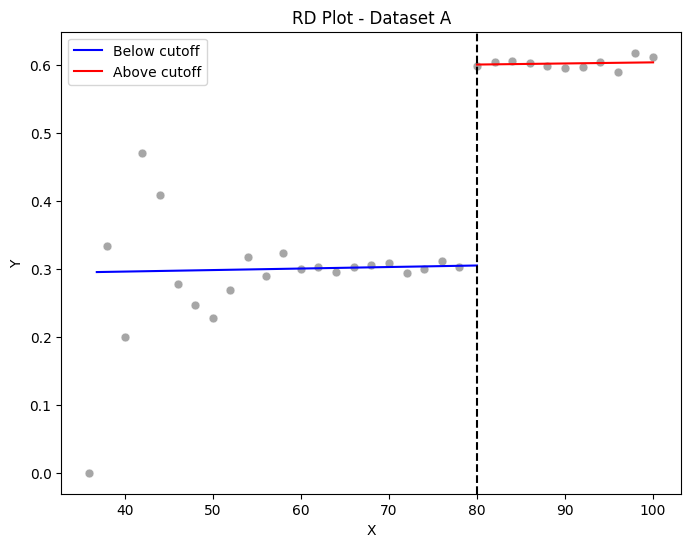

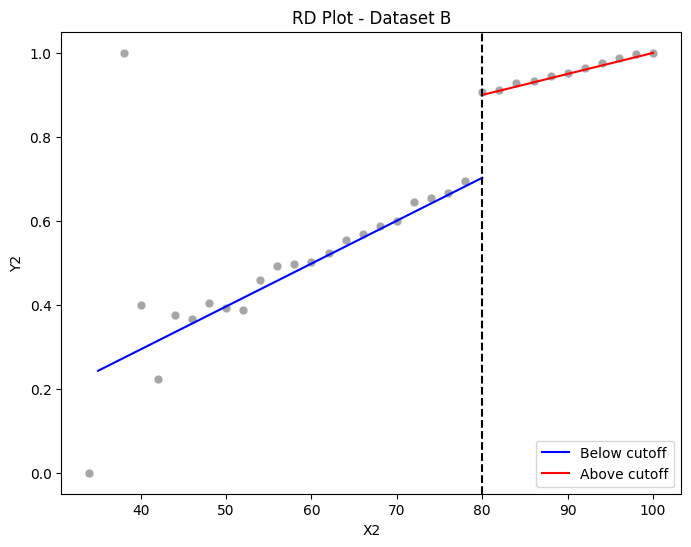

In [19]:

def fast_rd_plot(df, xcol, ycol, cutoff=80, binwidth=2, title="RD Plot"):
    """
    Fast regression discontinuity plot:
    - Bins X into intervals and plots mean Y in each bin
    - Fits separate OLS lines below and above the cutoff
    """

    # --- Bin averages for scatter ---
    df = df.copy()
    df['bin'] = (df[xcol] // binwidth) * binwidth
    bin_means = df.groupby('bin')[ycol].mean().reset_index()

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=bin_means['bin'], y=bin_means[ycol], s=40, color="gray", alpha=0.7)

    # --- Fit separate OLS lines ---
    below = df[df[xcol] < cutoff]
    above = df[df[xcol] >= cutoff]

    if len(below) > 0:
        model_below = smf.ols(f"{ycol} ~ {xcol}", data=below).fit()
        x_vals = np.linspace(below[xcol].min(), cutoff, 100)
        y_vals = model_below.predict(pd.DataFrame({xcol: x_vals}))
        plt.plot(x_vals, y_vals, color="blue", label="Below cutoff")

    if len(above) > 0:
        model_above = smf.ols(f"{ycol} ~ {xcol}", data=above).fit()
        x_vals = np.linspace(cutoff, above[xcol].max(), 100)
        y_vals = model_above.predict(pd.DataFrame({xcol: x_vals}))
        plt.plot(x_vals, y_vals, color="red", label="Above cutoff")

    # --- Cutoff line ---
    plt.axvline(cutoff, color="black", linestyle="--")
    plt.title(title)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.legend()
    plt.show()

# Plot for dataset A
fast_rd_plot(df2a, "X", "Y", cutoff=80, title="RD Plot - Dataset A")

# Plot for dataset B
fast_rd_plot(df2b, "X2", "Y2", cutoff=80, title="RD Plot - Dataset B")

In [ ]:
# Reflection Question 1

# Step 1: Create bins of W (quartiles here, but you can change q=10 for deciles)
df1['W_bin'] = pd.qcut(df1['W'], q=4, duplicates='drop')

# Step 2: Compute Wald ratio within each bin
results = []
for wbin, group in df1.groupby('W_bin'):
    delta_Y = group.loc[group['Z']==1, 'Y'].mean() - group.loc[group['Z']==0, 'Y'].mean()
    delta_X = group.loc[group['Z']==1, 'X'].mean() - group.loc[group['Z']==0, 'X'].mean()
    
    if delta_X != 0:  # avoid division by zero
        ratio = delta_Y / delta_X
        results.append(ratio)

# Step 3: Average across bins
iv_estimate = np.mean(results)
print("Stratified IV estimate:", iv_estimate)

Stratified IV estimate: 1.5148322357190138


C:\Users\tbran\AppData\Local\Temp\ipykernel_3504\2227395667.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for wbin, group in df1.groupby('W_bin'):


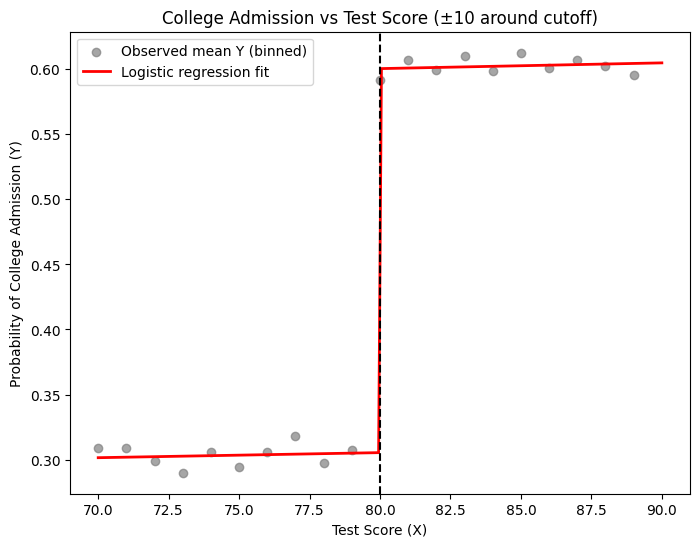

In [ ]:
# Reflection Question 2


# Assume df2a has columns X (test score) and Y (college outcome)
cutoff = 80
window = 10  # +/- 10 points around cutoff

# Restrict to scores near cutoff
df_window = df2a[(df2a['X'] >= cutoff - window) & (df2a['X'] <= cutoff + window)].copy()
df_window['treat'] = (df_window['X'] >= cutoff).astype(int)

# --- Bin averages for observed Y ---
binwidth = 1
df_window['bin'] = (df_window['X'] // binwidth) * binwidth
bin_means = df_window.groupby('bin')['Y'].mean().reset_index()

# --- Logistic regression ---
logit_model = smf.logit("Y ~ X + treat", data=df_window).fit(disp=0)

# Generate smooth predictions
x_vals = np.linspace(cutoff - window, cutoff + window, 200)
pred_df = pd.DataFrame({'X': x_vals, 'treat': (x_vals >= cutoff).astype(int)})
pred_df['pred_prob'] = logit_model.predict(pred_df)

# --- Plot ---
plt.figure(figsize=(8,6))

# Plot observed averages (empirical probability)
plt.scatter(bin_means['bin'], bin_means['Y'], color="gray", alpha=0.7, label="Observed mean Y (binned)")

# Plot logistic regression curve
plt.plot(pred_df['X'], pred_df['pred_prob'], color="red", linewidth=2, label="Logistic regression fit")

# Cutoff line
plt.axvline(cutoff, color="black", linestyle="--")

plt.xlabel("Test Score (X)")
plt.ylabel("Probability of College Admission (Y)")
plt.title("College Admission vs Test Score (±10 around cutoff)")
plt.legend()
plt.show()


In [ ]:
df['event'] = (df['time'] >= 50).astype(int)
df['time_sq'] = df['time']**2
df['time_event'] = df['time'] * df['event']
df['time_sq_event'] = df['time_sq'] * df['event']

model = smf.ols('value1 ~ time + time_sq + event + time_event + time_sq_event', data=df).fit()
print(model.summary())


Estimated variance of the sample mean: 0.006301698167823318
